In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline

In [29]:
df = pd.read_csv("attribution_data.csv")
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [35]:
def calc_attribution_linear(click_pos, total_clicks):
    """
    Helper function to calculate linear attribution.
    """
    return 1 / total_clicks  # Equal credit for each touchpoint

def linear_model(df, conv_col, channel_col, user_id):
    """
    Optimized Linear Multi-Touch Attribution Model
    """
    # Step 1: Filter data for converted users
    converted_users = df[df[conv_col] == 1][user_id].unique()
    df_conv = df[df[user_id].isin(converted_users)].copy()
    
    # Step 2: Add intermediate columns
    df_conv['clicks'] = df_conv[user_id].map(Counter(df_conv[user_id]))  # Total clicks per user
    df_conv['click_pos'] = df_conv.groupby(user_id).cumcount() + 1       # Position in the path

    # Step 3: Calculate Linear weights
    df_conv['Linear'] = df_conv.apply(
        lambda x: calc_attribution_linear(x['click_pos'], x['clicks']) * 100, axis=1
    )

    # Step 4: Aggregate weights by channel
    channel_weights = df_conv.groupby(channel_col)['Linear'].mean().reset_index()

    # Step 5: Normalize to percentage
    total_weight = channel_weights['Linear'].sum()
    channel_weights['Weight (%)'] = round((channel_weights['Linear'] / total_weight) * 100, 2)

    # Step 6: Prepare the final output
    channel_weights.drop(columns=['Linear'], inplace=True)
    channel_weights = channel_weights.sort_values(by='Weight (%)', ascending=False)
    channel_weights.set_index(channel_col, inplace=True)
    
    return channel_weights

In [36]:
linear_model = linear_model(df, 'conversion', 'channel', 'cookie')
linear_model

,Weight (%)
channel,
Paid Search,27.63
Online Display,26.43
Instagram,16.56
Facebook,16.28
Online Video,13.11


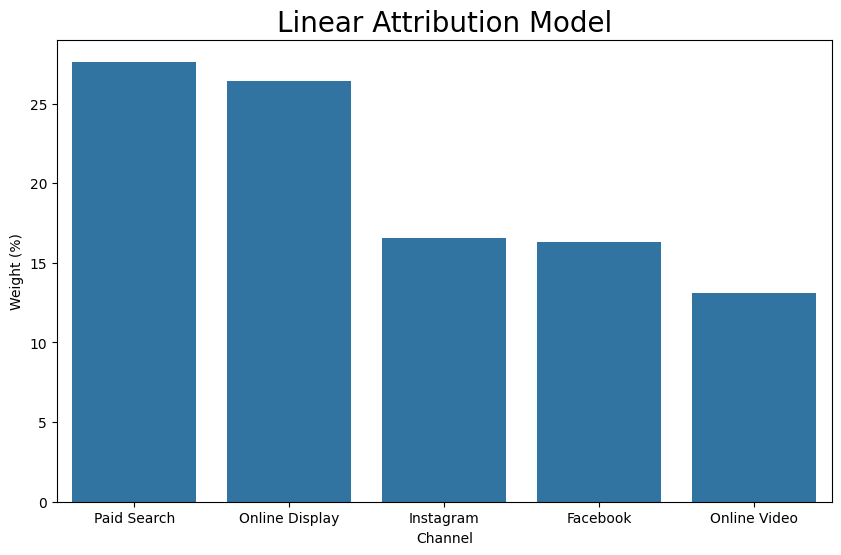

In [39]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=linear_model, x=linear_model.index, y="Weight (%)")
plt.xlabel("Channel")
plt.title("Linear Attribution Model",fontsize=20)
plt.savefig('plot/linear_model.png')